In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.linear_model import Perceptron
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

In [2]:
df = pd.read_csv('ner_dataset.csv', encoding = "ISO-8859-1")
df = df[:100000]
df.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [3]:
df.isnull().sum()

Sentence #    95456
Word              0
POS               0
Tag               0
dtype: int64

In [4]:
df = df.fillna(method='ffill')

In [5]:

#We have 4,544 sentences that contain 10,922 unique words and tagged by 17 tags.

df['Sentence #'].nunique(), df.Word.nunique(), df.Tag.nunique()

(4544, 10922, 17)

In [6]:

df.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


In [7]:
df.groupby('Tag').size().reset_index(name='counts')

,Tag,counts
0,B-art,75
1,B-eve,53
2,B-geo,3303
3,B-gpe,1740
4,B-nat,30
5,B-org,1876
6,B-per,1668
7,B-tim,1823
8,I-art,43
9,I-eve,47


In [8]:
X = df.drop('Tag', axis=1)
X.head()


,Sentence #,Word,POS
0,Sentence: 1,Thousands,NNS
1,Sentence: 1,of,IN
2,Sentence: 1,demonstrators,NNS
3,Sentence: 1,have,VBP
4,Sentence: 1,marched,VBN


In [9]:

X.columns

Index(['Sentence #', 'Word', 'POS'], dtype='object')

In [10]:
v = DictVectorizer(sparse=False)
X = v.fit_transform(X.to_dict('records'))
X.shape

(100000, 15507)

In [11]:
y = df.Tag.values

In [12]:

classes = np.unique(y)

In [13]:
classes = classes.tolist()
classes

['B-art',
 'B-eve',
 'B-geo',
 'B-gpe',
 'B-nat',
 'B-org',
 'B-per',
 'B-tim',
 'I-art',
 'I-eve',
 'I-geo',
 'I-gpe',
 'I-nat',
 'I-org',
 'I-per',
 'I-tim',
 'O']

In [14]:
X.shape, y.shape

((100000, 15507), (100000,))

# NER using Bidirectional LSTM

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output

In [2]:
dframe = pd.read_csv("ner.csv", encoding = "ISO-8859-1", error_bad_lines=False)

b'Skipping line 281837: expected 25 fields, saw 34\n'


In [3]:
dframe.head()

,Unnamed: 0,lemma,next-lemma,next-next-lemma,next-next-pos,next-next-shape,next-next-word,next-pos,next-shape,next-word,...,prev-prev-lemma,prev-prev-pos,prev-prev-shape,prev-prev-word,prev-shape,prev-word,sentence_idx,shape,word,tag
0,0,thousand,of,demonstr,NNS,lowercase,demonstrators,IN,lowercase,of,...,__start2__,__START2__,wildcard,__START2__,wildcard,__START1__,1.0,capitalized,Thousands,O
1,1,of,demonstr,have,VBP,lowercase,have,NNS,lowercase,demonstrators,...,__start1__,__START1__,wildcard,__START1__,capitalized,Thousands,1.0,lowercase,of,O
2,2,demonstr,have,march,VBN,lowercase,marched,VBP,lowercase,have,...,thousand,NNS,capitalized,Thousands,lowercase,of,1.0,lowercase,demonstrators,O
3,3,have,march,through,IN,lowercase,through,VBN,lowercase,marched,...,of,IN,lowercase,of,lowercase,demonstrators,1.0,lowercase,have,O
4,4,march,through,london,NNP,capitalized,London,IN,lowercase,through,...,demonstr,NNS,lowercase,demonstrators,lowercase,have,1.0,lowercase,marched,O


In [4]:
#Data preprocessing

dframe.columns

Index(['Unnamed: 0', 'lemma', 'next-lemma', 'next-next-lemma', 'next-next-pos',
       'next-next-shape', 'next-next-word', 'next-pos', 'next-shape',
       'next-word', 'pos', 'prev-iob', 'prev-lemma', 'prev-pos',
       'prev-prev-iob', 'prev-prev-lemma', 'prev-prev-pos', 'prev-prev-shape',
       'prev-prev-word', 'prev-shape', 'prev-word', 'sentence_idx', 'shape',
       'word', 'tag'],
      dtype='object')

In [5]:
#We want word, pos, sentence_idx and tag as an input

dataset=dframe.drop(['Unnamed: 0', 'lemma', 'next-lemma', 'next-next-lemma', 'next-next-pos',
       'next-next-shape', 'next-next-word', 'next-pos', 'next-shape',
       'next-word', 'prev-iob', 'prev-lemma', 'prev-pos',
       'prev-prev-iob', 'prev-prev-lemma', 'prev-prev-pos', 'prev-prev-shape',
       'prev-prev-word', 'prev-shape', 'prev-word'],axis=1)

In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050795 entries, 0 to 1050794
Data columns (total 5 columns):
pos             1050794 non-null object
sentence_idx    1050794 non-null float64
shape           1050794 non-null object
word            1050794 non-null object
tag             1050794 non-null object
dtypes: float64(1), object(4)
memory usage: 40.1+ MB


In [7]:
dataset.head()

,pos,sentence_idx,shape,word,tag
0,NNS,1.0,capitalized,Thousands,O
1,IN,1.0,lowercase,of,O
2,NNS,1.0,lowercase,demonstrators,O
3,VBP,1.0,lowercase,have,O
4,VBN,1.0,lowercase,marched,O


In [8]:
dataset=dataset.drop(['shape'],axis=1)

In [9]:
dataset.head()

,pos,sentence_idx,word,tag
0,NNS,1.0,Thousands,O
1,IN,1.0,of,O
2,NNS,1.0,demonstrators,O
3,VBP,1.0,have,O
4,VBN,1.0,marched,O


In [10]:
class SentenceGetter(object):
    
    def __init__(self, dataset):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [(w,p, t) for w,p, t in zip(s["word"].values.tolist(),
                                                       s['pos'].values.tolist(),
                                                        s["tag"].values.tolist())]
        self.grouped = self.dataset.groupby("sentence_idx").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [11]:
getter = SentenceGetter(dataset)

In [12]:
sentences = getter.sentences

In [13]:
print(sentences[0:1])

[[('Thousands', 'NNS', 'O'), ('of', 'IN', 'O'), ('demonstrators', 'NNS', 'O'), ('have', 'VBP', 'O'), ('marched', 'VBN', 'O'), ('through', 'IN', 'O'), ('London', 'NNP', 'B-geo'), ('to', 'TO', 'O'), ('protest', 'VB', 'O'), ('the', 'DT', 'O'), ('war', 'NN', 'O'), ('in', 'IN', 'O'), ('Iraq', 'NNP', 'B-geo'), ('and', 'CC', 'O'), ('demand', 'VB', 'O'), ('the', 'DT', 'O'), ('withdrawal', 'NN', 'O'), ('of', 'IN', 'O'), ('British', 'JJ', 'B-gpe'), ('troops', 'NNS', 'O'), ('from', 'IN', 'O'), ('that', 'DT', 'O'), ('country', 'NN', 'O'), ('.', '.', 'O'), ('Thousands', 'NNS', 'O'), ('of', 'IN', 'O'), ('demonstrators', 'NNS', 'O'), ('have', 'VBP', 'O'), ('marched', 'VBN', 'O'), ('through', 'IN', 'O'), ('London', 'NNP', 'B-geo'), ('to', 'TO', 'O'), ('protest', 'VB', 'O'), ('the', 'DT', 'O'), ('war', 'NN', 'O'), ('in', 'IN', 'O'), ('Iraq', 'NNP', 'B-geo'), ('and', 'CC', 'O'), ('demand', 'VB', 'O'), ('the', 'DT', 'O'), ('withdrawal', 'NN', 'O'), ('of', 'IN', 'O'), ('British', 'JJ', 'B-gpe'), ('troops'

In [14]:
maxlen = max([len(s) for s in sentences])
print ('Maximum sequence length:', maxlen)

Maximum sequence length: 140


In [15]:
# Check how long sentences are so that we can pad them
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")

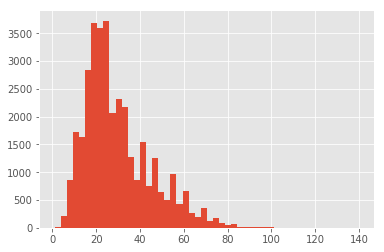

In [16]:
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [17]:
words = list(set(dataset["word"].values))
words.append("ENDPAD")

In [18]:
n_words = len(words); n_words

30174

In [19]:
tags = list(set(dataset["tag"].values))

In [20]:
n_tags = len(tags); n_tags

18

# Converting words to numbers and numbers to words

In [21]:
word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [22]:
word2idx['Obama']

146

In [23]:
tag2idx['B-geo']

7

In [24]:
from keras.preprocessing.sequence import pad_sequences
X = [[word2idx[w[0]] for w in s] for s in sentences]

Using TensorFlow backend.


In [25]:
X = pad_sequences(maxlen=140, sequences=X, padding="post",value=n_words - 1)

In [26]:
y = [[tag2idx[w[2]] for w in s] for s in sentences]

In [27]:
y = pad_sequences(maxlen=140, sequences=y, padding="post", value=tag2idx["O"])

In [28]:
from keras.utils import to_categorical
y = [to_categorical(i, num_classes=n_tags) for i in y]

In [29]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [30]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional

In [31]:
input = Input(shape=(140,))
model = Embedding(input_dim=n_words, output_dim=140, input_length=140)(input)
model = Dropout(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(n_tags, activation="softmax"))(model)  # softmax output layer

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [32]:
model = Model(input, out)

In [33]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [34]:
history = model.fit(X_train, np.array(y_train), batch_size=32, epochs=1, validation_split=0.2, verbose=1)

Instructions for updating:
Use tf.cast instead.
Train on 22512 samples, validate on 5629 samples
Epoch 1/1
22512/22512 [==============================] - 175s 8ms/step - loss: 0.1294 - acc: 0.9749 - val_loss: 0.0413 - val_acc: 0.9889


In [35]:
i = 0
p = model.predict(np.array([X_test[i]]))
p = np.argmax(p, axis=-1)
print("{:15} ({:5}): {}".format("Word", "True", "Pred"))
for w,pred in zip(X_test[i],p[0]):
    print("{:15}: {}".format(words[w],tags[pred]))

Word            (True ): Pred
The            : O
region         : O
is             : O
located        : O
along          : O
a              : O
major          : O
Asian          : O
migratory      : O
route          : O
for            : O
birds          : O
.              : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
E

In [36]:
p[0]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)